In [1]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
from astroquery.simbad import Simbad
from astroquery.vizier import Vizier
from astroquery.exceptions import BlankResponseWarning

from exod.utils.logger import logger
from exod.pre_processing.download_observations import read_observation_ids
from exod.pre_processing.read_events import get_PN_image_file, get_filtered_events_files
from exod.post_processing.collate_results import combine_all_region_files, crossmatch_simbad, get_df_regions_no_crossmatch, get_df_regions_with_crossmatch, crossmatch_vizier, plot_simbad_crossmatch_image

In [2]:
df_all_regions = combine_all_region_files()
df_all_regions

2024-02-07 15:59:41,827 - INFO - collate_results.py:combine_all_region_files - Combining all region files
2024-02-07 15:59:41,832 - INFO - collate_results.py:combine_all_region_files - Found 53 csv files
2024-02-07 15:59:41,838 - INFO - collate_results.py:combine_all_region_files - /home/nkhan/EXOD2/data/results/0770380401/regions.csv rows: 115
2024-02-07 15:59:41,843 - INFO - collate_results.py:combine_all_region_files - /home/nkhan/EXOD2/data/results/0863401101/regions.csv rows: 17
2024-02-07 15:59:41,846 - INFO - collate_results.py:combine_all_region_files - /home/nkhan/EXOD2/data/results/0670170501/regions.csv rows: 19
2024-02-07 15:59:41,848 - INFO - collate_results.py:combine_all_region_files - /home/nkhan/EXOD2/data/results/0911790601/regions.csv rows: 26
2024-02-07 15:59:41,850 - INFO - collate_results.py:combine_all_region_files - /home/nkhan/EXOD2/data/results/0411980401/regions.csv rows: 6
2024-02-07 15:59:41,853 - INFO - collate_results.py:combine_all_region_files - /home/n

,label,bbox-0,bbox-1,bbox-2,bbox-3,weighted_centroid-0,weighted_centroid-1,intensity_mean,equivalent_diameter_area,area_bbox,X,Y,ra,dec
0,0,77,98,78,99,77.000000,98.000000,2.428428,1.128379,1.0,282.718147,295.227799,173.463865,0.722885
1,1,38,79,39,80,38.000000,79.000000,2.259467,1.128379,1.0,185.142857,247.691120,173.572289,0.670064
2,2,123,82,125,84,123.532779,82.622896,2.107219,2.256758,4.0,399.139925,256.755354,173.334498,0.680137
3,3,68,55,70,58,68.428261,55.929858,2.050193,2.523133,6.0,261.272252,189.971228,173.487694,0.605933
4,4,53,152,54,153,53.000000,152.000000,1.914154,1.128379,1.0,222.671815,430.332046,173.530593,0.872999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114,5,40,112,41,113,40.000000,112.000000,1.863147,1.128379,1.0,160.123552,377.791506,353.774539,39.408442
1115,6,60,86,61,87,60.000000,86.000000,1.836874,1.128379,1.0,210.162162,312.741313,353.702412,39.336287
1116,7,114,94,116,96,114.453411,94.564271,1.776080,2.256758,4.0,346.400812,334.168522,353.506682,39.360203
1117,8,84,80,86,82,84.441313,80.558687,1.058936,1.595769,4.0,271.312628,299.127527,353.614548,39.321250


In [3]:
tab_res = crossmatch_simbad(df_region=df_all_regions, radius=0.5*u.arcmin)
df_all_regions_no_crossmatch = get_df_regions_no_crossmatch(df_regions=df_all_regions, tab_res=tab_res)
df_all_regions_with_crossmatch = get_df_regions_with_crossmatch(df_regions=df_all_regions, tab_res=tab_res)


2024-02-07 15:59:53,025 - INFO - collate_results.py:crossmatch_simbad - Crossmatching df_region len=1119 with SIMBAD, radius=0.5 arcmin
2024-02-07 15:59:53,026 - INFO - collate_results.py:crossmatch_simbad - Creating SkyCoord Object
2024-02-07 15:59:53,096 - INFO - collate_results.py:crossmatch_simbad - Querying Region (This can take a while)
2024-02-07 16:00:05,253 - INFO - collate_results.py:crossmatch_simbad - Found 890 results
2024-02-07 16:00:05,253 - INFO - collate_results.py:crossmatch_simbad - Appending region coordinates to table...
2024-02-07 16:00:05,826 - INFO - collate_results.py:crossmatch_simbad - Calculating seperations...
2024-02-07 16:00:06,070 - INFO - collate_results.py:_get_table_id_col - Getting table ID column
2024-02-07 16:00:06,072 - INFO - collate_results.py:get_df_regions_no_crossmatch - 800 / 1119 regions have no counterparts with SIMBAD
2024-02-07 16:00:06,072 - INFO - collate_results.py:_get_table_id_col - Getting table ID column
2024-02-07 16:00:06,073 - 

In [4]:
tab_res.to_pandas()

,MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,...,Distance_merr,Distance_perr,Distance_method,Distance_bibcode,SCRIPT_NUMBER_ID,RA_REGION_DEG,DEC_REGION_DEG,SEP_DEG,SEP_ARCMIN,SEP_ARCSEC
0,H-ATLAS J113320.2+004053,11 33 20.202,+00 40 53.76,7,7,NaN,NaN,0,D,s,...,NaN,NaN,,,2,173.334498,0.680137,0.001498,0.089888,5.393258
1,[VV2006] J113320.1+004052,11 33 20.0557,+00 40 52.837,12,12,0.041997,0.058800,0,A,R,...,NaN,NaN,,,2,173.334498,0.680137,0.001525,0.091505,5.490284
2,3XMM J113407.5+005223,11 34 07.43,+00 52 24.7,6,6,NaN,NaN,0,D,X,...,NaN,NaN,,,4,173.530593,0.872999,0.000643,0.038574,2.314447
3,[AL2020] XT 151219 Host G,11 34 07.29,+00 52 26.7,6,6,NaN,NaN,0,D,O,...,NaN,NaN,,,4,173.530593,0.872999,0.001106,0.066354,3.981211
4,[VV2006] J113403.6+004230,11 34 03.5592,+00 42 30.639,8,8,590.299988,412.200012,0,C,,...,NaN,NaN,,,6,173.516158,0.707391,0.001736,0.104190,6.251378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,2MASX J02231298+4259162,02 23 12.9787,+42 59 16.063,14,14,0.516400,0.599100,90,C,O,...,NaN,NaN,,2016AJ....152...50T,1107,35.798947,42.991161,0.005041,0.302467,18.148043
886,TYC 2839-34-1,02 23 11.9262,+42 55 29.789,14,14,0.074600,0.081600,90,A,O,...,-4.6215,4.6215,paral,2020yCat.1350....0G,1108,35.801242,42.924089,0.001419,0.085157,5.109428
887,2E 0220.0+4241,02 23 13.4,+42 55 33,5,5,NaN,NaN,0,D,,...,NaN,NaN,,,1108,35.801242,42.924089,0.003788,0.227250,13.635023
888,2MASS J23343040+3921000,23 34 30.4145,+39 21 00.176,14,14,0.136200,0.112500,90,A,O,...,NaN,NaN,,,1109,353.627548,39.349471,0.000859,0.051522,3.091310


2024-02-07 16:01:35,341 - INFO - read_events.py:get_PN_image_file - Getting Image files for observation: 0886121001


KeyError: 'obsid'

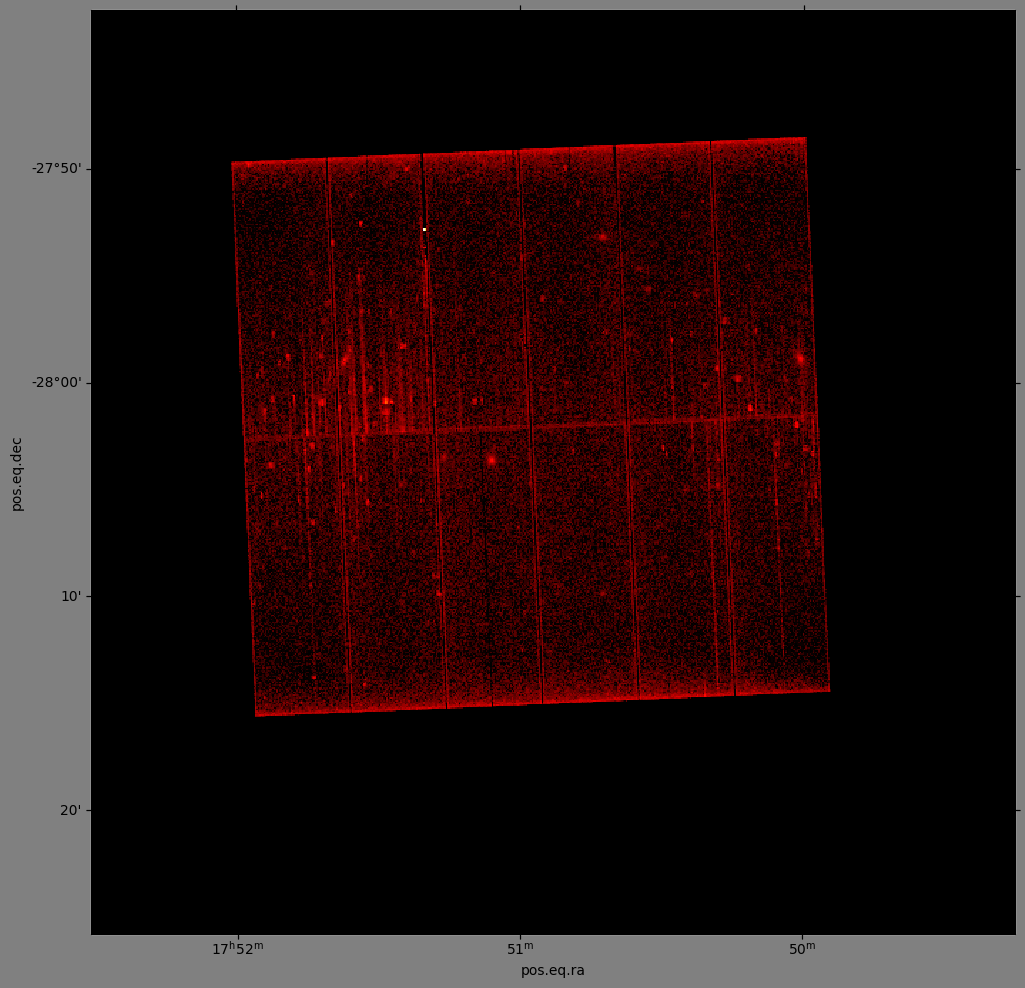

In [6]:
obsids = read_observation_ids('../data/observations.txt')
for obsid in obsids:
    try:
        plot_simbad_crossmatch_image(obsid=obsid,
                                     df_all_regions_no_crossmatch=df_all_regions_no_crossmatch,
                                     df_all_regions_with_crossmatch=df_all_regions_with_crossmatch,
                                     tab_res=tab_res)
    except FileNotFoundError as e:
        print(f'{e}')

In [ ]:
# https://cdsarc.cds.unistra.fr/viz-bin/cat/I/355
# http://glade.elte.hu/
# https://vizier.unistra.fr/viz-bin/VizieR-3?-source=IX/69/xmm4d13s
# use xmm not stacked catalogue too
vizier_catalogues = ['I/355/gaiadr3', 'GLADE+', 'IX/69/xmm4d13s']
catalog = vizier_catalogues[2]

In [ ]:
for c in vizier_catalogues:
    tab_res = crossmatch_vizier(df_region=df_all_regions, radius=10*u.arcsec, catalog=c)
    print(tab_res)

In [ ]:
tab_res

In [ ]:
from astroquery.simbad import Simbad

In [ ]:
?Simbad.query_region

In [ ]:
?Simbad.query_region